# Loading/ Plotting Inputs

In [1]:
import pickle
import gzip

file1 = '/n/holystore01/LABS/iaifi_lab/Lab/creissel/neutrino_mass/Project8SampleData_WithoutNoise_Scan1.pkl.gz'
file2 = '/n/holystore01/LABS/iaifi_lab/Lab/creissel/neutrino_mass/Project8SampleData_WithoutNoise_Scan2.pkl.gz'

In [2]:
with gzip.open(file1, "rb") as f:
    data1 = pickle.load(f, encoding='bytes')

#with gzip.open(file2, "rb") as f:
#    data2 = pickle.load(f, encoding='bytes')

In [3]:
data1

,starting_energy_eV,carrier_frequency_Hz,axial_frequency_Hz,pitch_angle_deg,start_time,end_time,slope_Hz,radius,radius_phase,time_series
0,18600.0,2.591508e+10,8.106290e+06,88.1,2.729529e-09,0.001,3.645203e+08,0.001013,-0.546766,"[0.0, 0.0, 0.0012500000000000011, 0.0021874999..."
1,18600.0,2.590414e+10,3.208595e+06,89.7,2.729529e-09,0.001,3.827198e+08,0.006157,3.227287,"[0.0, 0.0, 0.0009375000000000008, 0.0018750000..."
2,18600.0,2.590580e+10,6.182955e+06,89.1,2.729529e-09,0.001,3.937996e+08,0.004894,-0.107886,"[0.0, 0.0, 0.0012500000000000011, 0.0021874999..."
3,18600.0,2.590515e+10,5.344463e+06,89.3,2.729529e-09,0.001,4.919983e+08,0.004168,3.268360,"[0.0, 0.0, 0.0018750000000000017, 0.00375, 0.0..."
4,18600.0,2.590449e+10,4.306579e+06,89.5,2.729529e-09,0.001,3.455434e+08,0.005889,-0.089608,"[0.0, 0.0, 0.0006250000000000006, 0.0007812500..."
...,...,...,...,...,...,...,...,...,...,...
264,18600.0,2.590585e+10,6.197984e+06,89.1,2.729529e-09,0.001,4.553698e+08,0.003901,-0.135491,"[0.0, 0.0, 0.0014062500000000012, 0.0032812499..."
265,18600.0,2.590954e+10,8.136435e+06,88.5,2.729529e-09,0.001,4.245743e+08,0.001938,-0.275260,"[0.0, 0.0, 0.0017187500000000015, 0.0034374999..."
266,18600.0,2.591156e+10,8.442133e+06,88.3,2.729529e-09,0.001,4.251937e+08,0.003179,3.308086,"[0.0, 0.0, 0.0014062500000000012, 0.0032812499..."
267,18600.0,2.590547e+10,5.811074e+06,89.2,2.729529e-09,0.001,3.937379e+08,0.001013,-0.546998,"[0.0, 0.0, 0.0007812500000000007, 0.0023437499..."


In [4]:
data1['axial_frequency_Hz']

0      8.106290e+06
1      3.208595e+06
2      6.182955e+06
3      5.344463e+06
4      4.306579e+06
           ...     
264    6.197984e+06
265    8.136435e+06
266    8.442133e+06
267    5.811074e+06
268    3.769141e+06
Name: axial_frequency_Hz, Length: 269, dtype: float64

Text(0, 0.5, '# Entries')

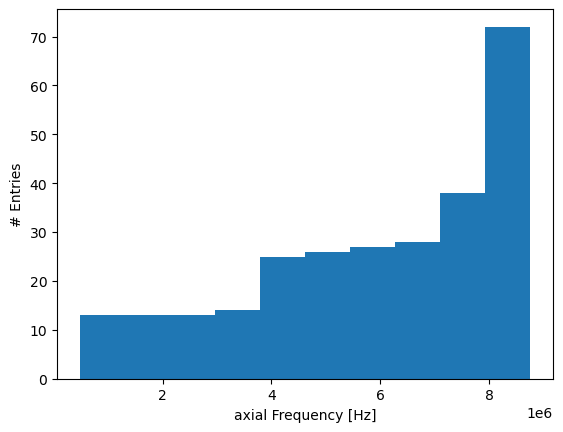

In [5]:
import matplotlib.pyplot as plt
plt.hist(data1['axial_frequency_Hz'])
#plt.hist(data2['axial_frequency_Hz'])
plt.xlabel('axial Frequency [Hz]')
plt.ylabel('# Entries')

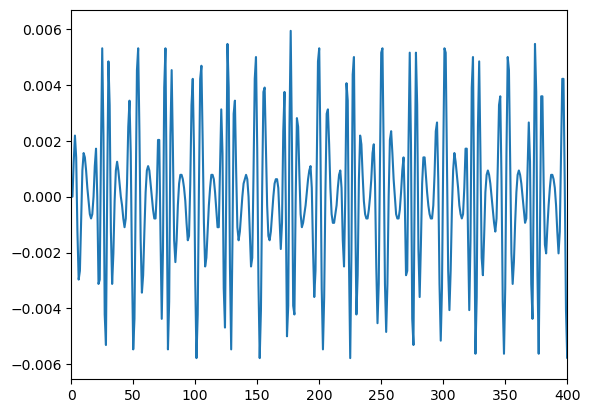

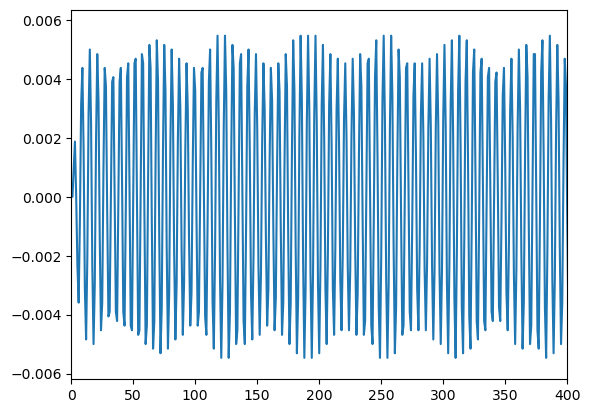

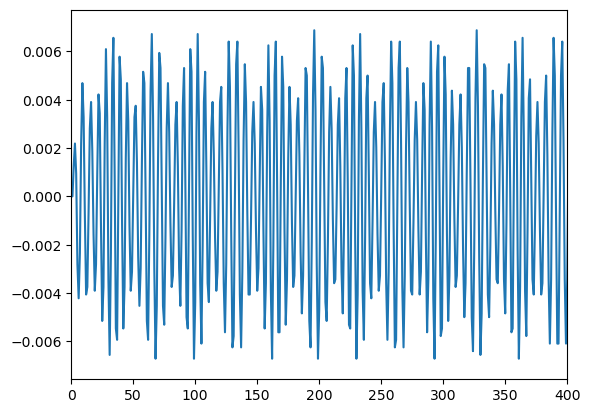

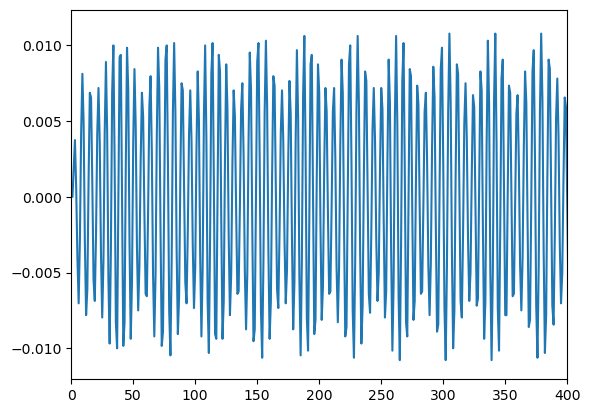

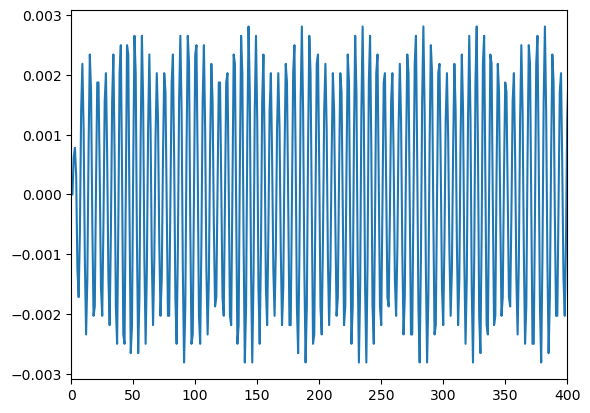

In [6]:
import numpy as np
for i in range(5):
    data = data1['time_series'][i]
    plt.plot(np.arange(0,data.shape[0],1), data)
    plt.xlim([0.0,0.4*10**(3)])
    plt.show()

Open questions:
- what length of the time series do we need? (apparently 4e5 measurements)
- can we potential downsample the time series to save ressources etc.

# Setting-up S4D Model

In [7]:
from models.s4d import S4D
import torch.nn as nn
dropout_fn = nn.Dropout2d

d_input = 1 # number of channels (here only one time series -> 1)
d_output = 1 # number of outputs (here regression, so one output, can be several, if we want to regress several quantities)

In [8]:
# definition of SSM here
class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input, d_model)
        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, 0.01))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))
        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)
            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)
            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)
            # Dropout on the output of the S4 block
            z = dropout(z)
            # Residual connection
            x = z + x
            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)
        x = x.transpose(-1, -2)
        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)
        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)
        x = torch.flatten(x)
        return x

In [9]:
# Model
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('==> Building model..')
model = S4Model(d_input=1, d_output=d_output, d_model=4, n_layers=2, dropout=0.0, prenorm=False)
model = model.to(device)
print('...done!')

==> Building model..
...done!


In [10]:
import torch.optim as optim
def setup_optimizer(model, lr, weight_decay, epochs):
    all_parameters = list(model.parameters())
    params = [p for p in all_parameters if not hasattr(p, "_optim")]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

criterion = nn.MSELoss()
optimizer, scheduler = setup_optimizer(model, lr=0.01, weight_decay=0.01, epochs=10)

Optimizer group 0 | 16 tensors | lr 0.01 | weight_decay 0.01
Optimizer group 1 | 6 tensors | lr 0.001 | weight_decay 0.0


# Actual training

In [11]:
from torch.utils.data import random_split, DataLoader, Dataset
class Dataloader(Dataset):
    def __init__(self, dataset=data1, length=0.4e4, variable='axial_frequency_Hz', normalize=True):
        X = dataset['time_series']
        X = np.stack(np.array(X))
        X = X[:,:int(length)]
        X = X[:, :, np.newaxis] # to fit the convention of the SSM
        y = dataset[variable]
        y = np.array(y)
        if normalize:
            mu_X = np.mean(X, axis=1)[:, :, np.newaxis]
            mu_y = np.mean(y)
            stds_X = np.std(X, axis=1)[:, :, np.newaxis]
            stds_y = np.std(y)
            X= (X-mu_X)/stds_X
            y= (y-mu_y)/stds_y
        
        self.timeseries = np.float32(X)
        self.vars = np.float32(y)
        
    def __len__(self):
        return self.vars.shape[0]
    
    def __getitem__(self, idx):
        times = self.timeseries[idx, :, :]
        var = self.vars[idx]
        return times, var
    
fulldata = Dataloader()
generator = torch.Generator().manual_seed(42) 
trainset, valset, testset = torch.utils.data.random_split(fulldata, [0.7,0.1,0.2], generator=generator)

In [12]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

tensor(-2.0932)


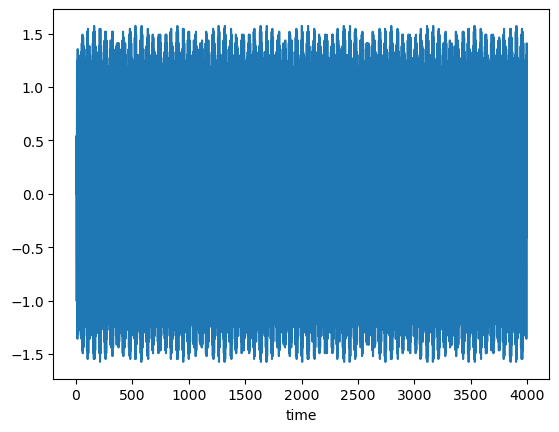

In [13]:
batch = next(iter(train_loader))
plt.plot(batch[0][0].numpy())
plt.xlabel("time")
print(batch[1][2])

In [14]:
best_loss = np.inf  # best test loss
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
doc_loss = []
doc_val = []

In [15]:
import os

# Training
from tqdm.auto import tqdm
def train():
    model.train()
    train_loss = 0
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f ' %
            (batch_idx, len(train_loader), train_loss/(batch_idx+1))
        )
        doc_loss.append(train_loss/(batch_idx+1))

def eval(epoch, dataloader, checkpoint=False):
    global best_loss
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1))
            )
            doc_val.append(eval_loss/(batch_idx+1))

    # Save checkpoint.
    if checkpoint:
        if loss < best_loss:
            state = {
                'model': model.state_dict(),
                'loss': loss,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_loss = loss
        

        return loss

pbar = tqdm(range(start_epoch, 50))
for epoch in pbar:
    if epoch == 0:
        pbar.set_description('Epoch: %d' % (epoch))
    else:
        pbar.set_description('Epoch: %d | Val loss: %1.3f' % (epoch, val_loss))
    train()
    val_loss = eval(epoch, valid_loader, checkpoint=True)
    eval(epoch, test_loader)
    scheduler.step()

/n/home03/creissel/miniforge3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch: 0:   0%|          | 0/50 [00:00<?, ?it/s]
0it [00:00, ?it/s]/n/home03/creissel/miniforge3/envs/ssm/lib/python3.10/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "

Batch Idx: (0/6) | Loss: 1.006 : : 0it [00:00, ?it/s]
Batch I

### Plotting and diagnostics of training

Text(0, 0.5, 'MSE loss value')

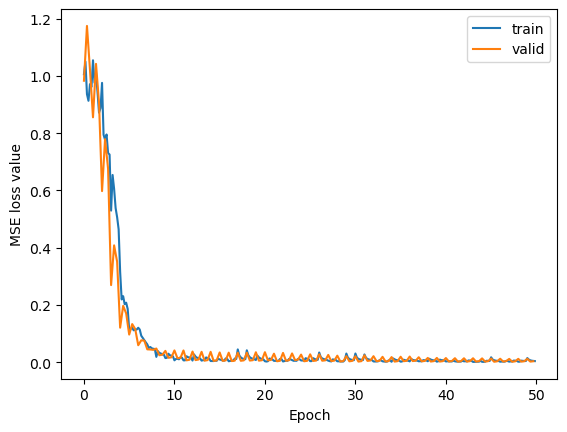

In [16]:
plt.plot(np.arange(0,len(doc_loss)/6.,1/6.), doc_loss, label='train')
plt.plot(np.arange(0, len(doc_val)/3., 1./3.), doc_val, label='valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss value')